In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr

c:\Users\MSReddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset_dir = r"C:\Users\MSReddy\OneDrive\Documents\VS code\Garbage_Class_DL_ML\TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

train_ds = image_dataset_from_directory(
    dataset_dir, validation_split=0.2, subset="training", seed=seed,
    shuffle=True, image_size=image_size, batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    dataset_dir, validation_split=0.2, subset="validation", seed=seed,
    shuffle=True, image_size=image_size, batch_size=batch_size
)

val_class = val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [4]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

class_names = train_ds.class_names

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09} {'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73} {'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42} {'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


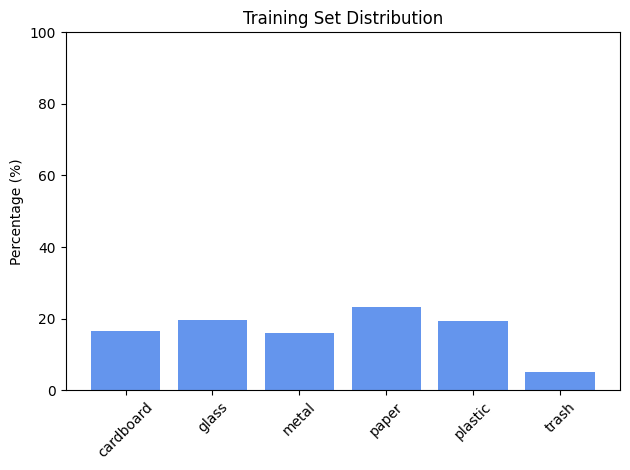

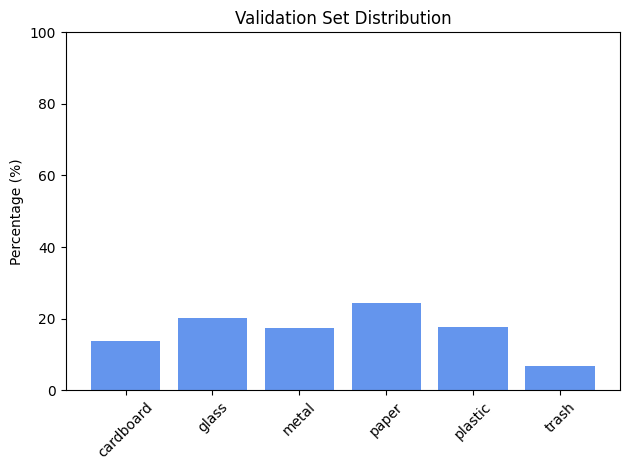

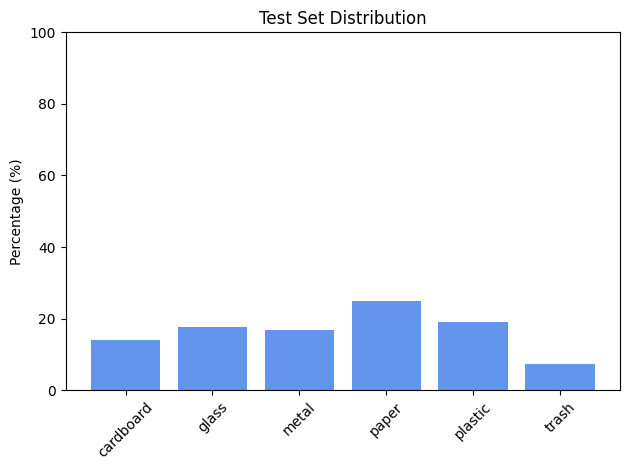

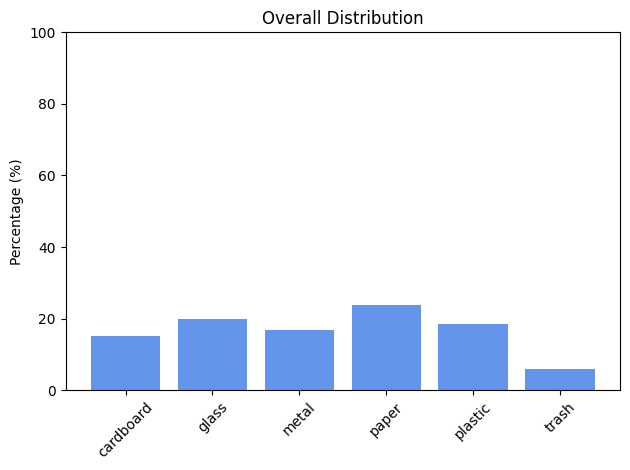

In [5]:
def count_distribution(dataset, class_names):
    total, counts = 0, {name: 0 for name in class_names}
    for _, labels in dataset:
        for label in labels.numpy():
            counts[class_names[label]] += 1
            total += 1
    return {k: round((v / total) * 100, 2) for k, v in counts.items()}

def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title); plt.ylabel('Percentage (%)'); plt.xticks(rotation=45)
    plt.ylim(0, 100); plt.tight_layout(); plt.show()

train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {k: round((train_dist[k] + val_dist[k]) / 2, 2) for k in class_names}

print(train_dist, val_dist, test_dist, overall_dist)
simple_bar_plot(train_dist, "Training Set Distribution")
simple_bar_plot(val_dist, "Validation Set Distribution")
simple_bar_plot(test_dist, "Test Set Distribution")
simple_bar_plot(overall_dist, "Overall Distribution")


In [6]:
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []
for _, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)
weights_array = compute_class_weight('balanced', classes=np.arange(len(class_names)), y=all_labels)
class_weights = {i: w for i, w in enumerate(weights_array)}

In [7]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [8]:
base_model = EfficientNetV2B2(include_top=False, weights='imagenet', include_preprocessing=True, input_shape=(124, 124, 3))
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_dat, epochs=15,
                    class_weight=class_weights, batch_size=batch_size,
                    callbacks=[early])

model.summary()
base_model.summary()


Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.3043 - loss: 1.6714 - val_accuracy: 0.5743 - val_loss: 1.2328
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.6344 - loss: 1.0645 - val_accuracy: 0.7390 - val_loss: 0.8957
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7852 - loss: 0.7141 - val_accuracy: 0.8072 - val_loss: 0.6080
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 62s 972ms/step - accuracy: 0.8401 - loss: 0.5107 - val_accuracy: 0.8313 - val_loss: 0.4767
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 59s 918ms/step - accuracy: 0.8654 - loss: 0.3988 - val_accuracy: 0.8554 - val_loss: 0.4376
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 919ms/step - accuracy: 0.9121 - loss: 0.2860 - val_accuracy: 0.8876 - val_loss: 0.3762
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 909ms/step - accuracy: 0.9317 - loss: 0.2202 - val_accuracy: 0.8835 - val_loss: 0.4210
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 60s 930ms/step - accuracy: 0.9296 - loss: 0.2081 - val_accuracy: 0.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 124, 124,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 124, 124,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 31, 31,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 31, 31,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

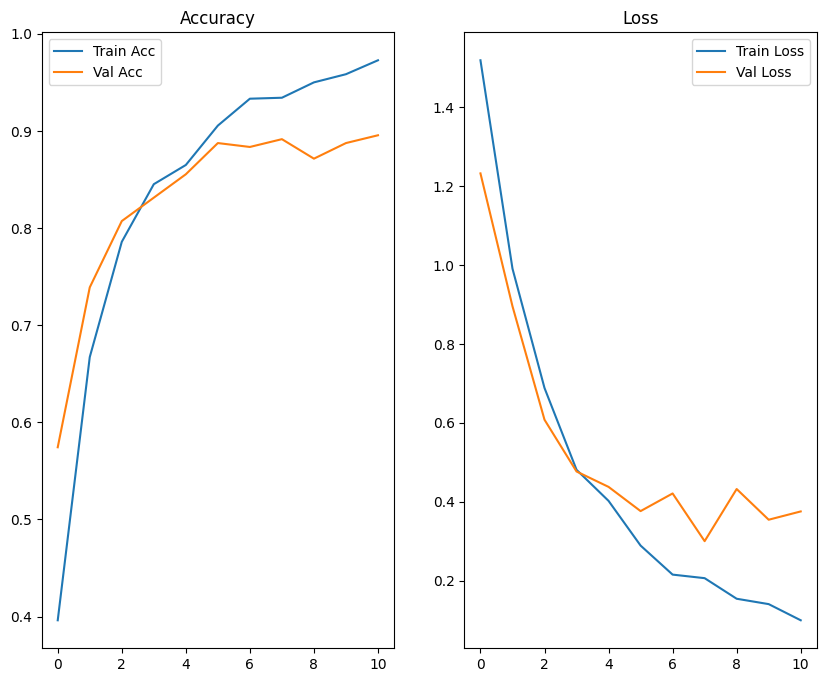

In [9]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(10,8))
plt.subplot(1,2,1); plt.plot(epochs_range, acc, label='Train Acc'); plt.plot(epochs_range, val_acc, label='Val Acc'); plt.title('Accuracy'); plt.legend()
plt.subplot(1,2,2); plt.plot(epochs_range, loss, label='Train Loss'); plt.plot(epochs_range, val_loss, label='Val Loss'); plt.title('Loss'); plt.legend()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.9044 - loss: 0.3485
Test Accuracy: 0.9023, Test Loss: 0.3535
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step
[[36  0  0  0  0  0]
 [ 0 43  4  0  3  0]
 [ 0  0 43  0  0  0]
 [ 7  0  1 56  0  2]
 [ 1  1  1  0 37  3]
 [ 0  0  2  0  0 16]]
              precision    recall  f1-score   support

   cardboard       0.82      1.00      0.90        36
       glass       0.98      0.86      0.91        50
       metal       0.84      1.00      0.91        43
       paper       1.00      0.85      0.92        66
     plastic       0.93      0.86      0.89        43
       trash       0.76      0.89      0.82        18

    accuracy                           0.90       256
   macro avg       0.89      0.91      0.89       256
weighted avg       0.91      0.90      0.90       256



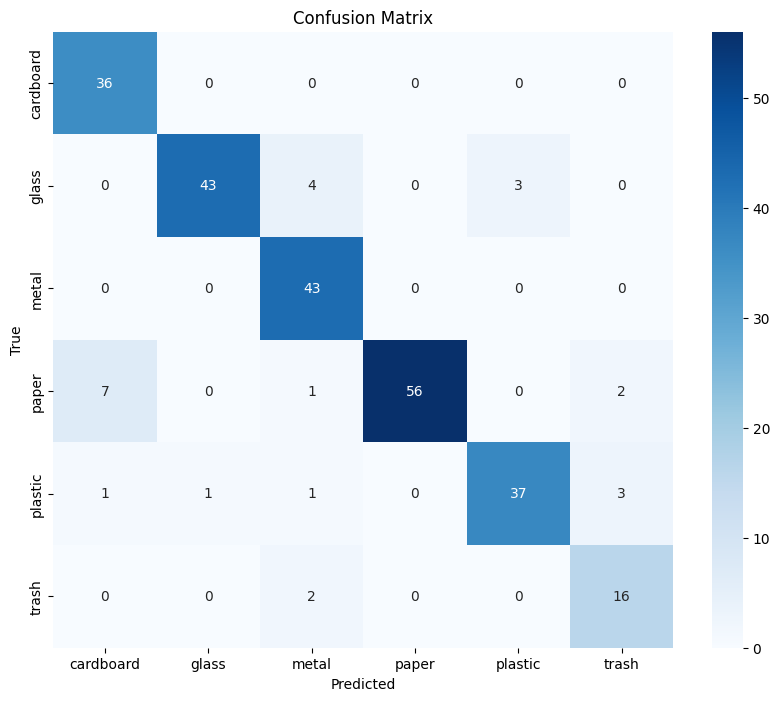

In [10]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test Accuracy: {accuracy:.4f}, Test Loss: {loss:.4f}')

y_true = np.concatenate([y.numpy() for _, y in test_ds_eval])
y_pred_probs = model.predict(test_ds_eval)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


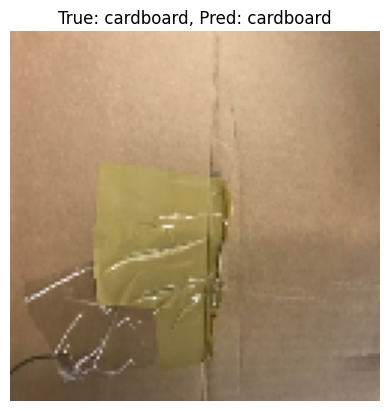

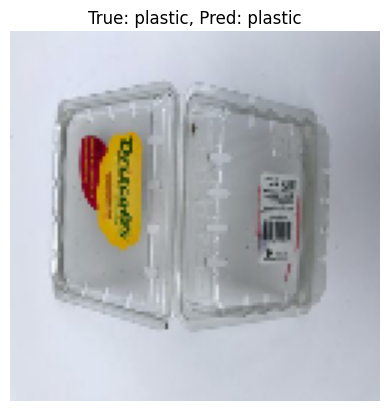

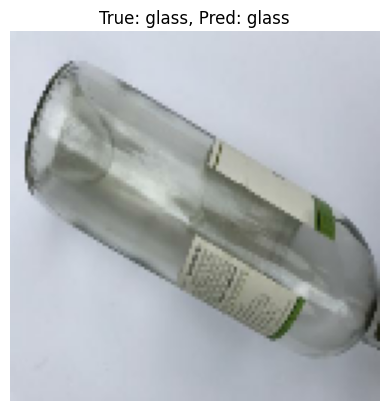

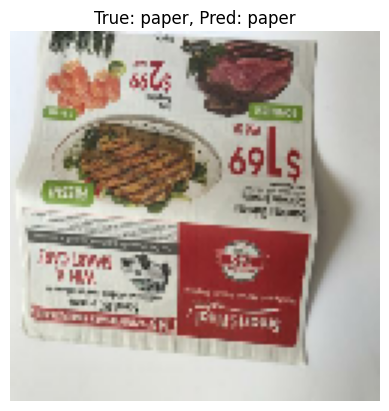

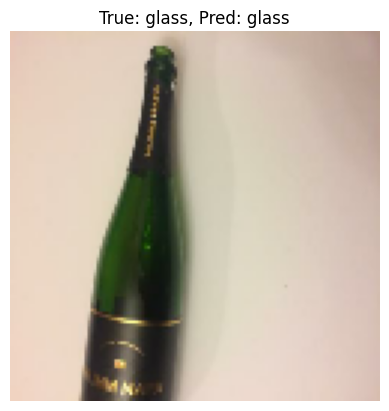

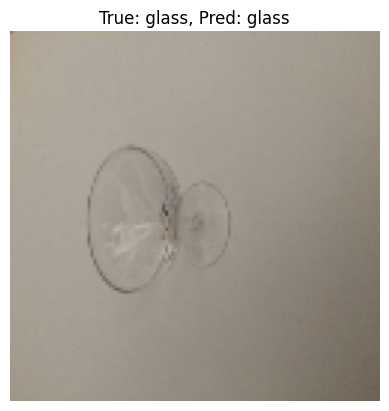

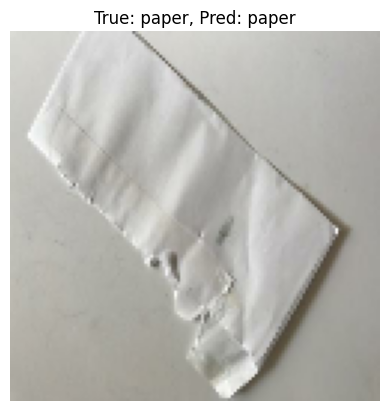

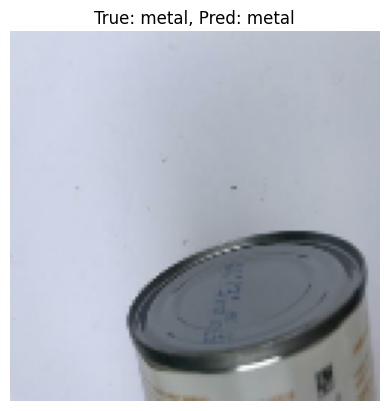

In [11]:
for images, labels in test_ds_eval.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")
        plt.axis("off")
        plt.show()


In [12]:
model.save('EfficientNetV2B2_Garbage.keras')
model = tf.keras.models.load_model('EfficientNetV2B2_Garbage.keras')

from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

def classify_image(img):
    img = img.resize((124, 124))
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_class = class_names[predicted_index]
    confidence = prediction[0][predicted_index]
    return f"Predicted: {predicted_class} (Confidence: {confidence:.2f})"

iface = gr.Interface(fn=classify_image, inputs=gr.Image(type="pil"), outputs="text")
iface.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
